In [3]:
####################################################################################################
# CR.WRFEnsemble.Figures: K. Lapo January 2016
####################################################################################################
# Plot WRF data
####################################################################################################
## Import statements
# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

# Data things
from netCDF4 import Dataset,num2date, date2num
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray
import kray

# import plotting
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context('talk')
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# OS interaction
import sys
import os

## Directory information
# Unix
if 'linux' in sys.platform:
    dir_pre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dir_pre = '/Users/karllapo/gdrive/'

# Google drive directories
dir_data = dir_pre+'SnowHydrology/proj/CloudClimatology/data'
dir_ens = '/WRFEnsemble/proc/'
dir_print = dir_pre+'SnowHydrology/proj/CloudClimatology/Graphics/'

# Directory for basemap pickle files
dir_bmap = dir_pre+'SnowHydrology/proj/CloudClimatology/data/basemap'

In [5]:
####################################################################################################
# Load Data (daily)
####################################################################################################
# Ground observations
os.chdir(dir_data)
grobs = xray.open_dataset('grobs.daily.nc')
grouping = ['north cv','south cv','west of crest','foothills','east of crest']

# WRF Ensemble
os.chdir(dir_data+dir_ens)
ensNames = ['WRF_ERAI_Morr','WRF_ERAI_Thom','WRF_ERAI_WSM6','WRF_NARR_Morr','WRF_NARR_Thom','WRF_NARR_WSM6']
numEns = np.size(ensNames)
wrfSWdwn = xray.Dataset()
wrfLWdwn = xray.Dataset()
for en in ensNames:
    temp = xray.open_dataset('CA.'+en+'.irrad.daily.nc')
    wrfSWdwn[en] = temp.SWdwn
    wrfLWdwn[en] = temp.LWdwn
    # Flip the data set - I did something stupid in processing the data :(
    for d in np.arange(wrfSWdwn.time.size):
        wrfSWdwn[en].values[d-1,:,:] = np.flipud(wrfSWdwn[en].values[d-1,:,:])
        wrfLWdwn[en].values[d-1,:,:] = np.flipud(wrfLWdwn[en].values[d-1,:,:])
        
wrfSWdwn = wrfSWdwn.rename({'lon':'longitude','lat':'latitude'})
wrfLWdwn = wrfLWdwn.rename({'lon':'longitude','lat':'latitude'})

In [6]:
####################################################################################################
## Find grid point containing each ground station
####################################################################################################
# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

# lat/lon for WRF
lon_rad = wrfSWdwn.longitude.values
lat_rad = wrfSWdwn.latitude.values  
# mesh
lonm, latm = np.meshgrid(lon_rad,lat_rad)

for en in ensNames:        
    # Empty numpy array
    to_merge = np.empty((wrfSWdwn.time.size,grobs.station.size))
    
    ## Product values in each grid containing station
    for stat in grobs.station.values:
        
        # Station index
        stat_ind = np.where(stat == grobs.station.values)
        # Distance to product grid lat-lon
        d = (latm-lat_stat[stat_ind])**2 + (lonm-lon_stat[stat_ind])**2
        # Index of closest product grid
        dind = np.where(d==np.amin(d))
        
        ## Grad grid values at the station, put into xray dataset
        # If the nearest grid point is missing data, fill with a nearby value 
        # (handle occasional missing values in mtclim grid)
        if (wrfSWdwn[en].values[:,dind[0][0],dind[1][0]] == 0).all() \
                | np.isnan(wrfSWdwn[en].values[:,dind[0][0],dind[1][0]]).all():
            to_merge[:,stat_ind[0]] = wrfSWdwn[en].values[:,dind[0][0]+1,dind[1][0],np.newaxis]
        # Fill with the grid point containing the station
        else:
            to_merge[:,stat_ind[0]] = wrfSWdwn[en].values[:,dind[0][0],dind[1][0],np.newaxis]
    
    ## Merge products w/ grobs xray structure
    to_merge_ds = xray.Dataset({en:(('time','station'),to_merge), \
                                    'time':wrfSWdwn.time.values,\
                                    'station':grobs.station.values})
    grobs = grobs.merge(to_merge_ds)

In [7]:
## Check out the contents of the Dataset
print(grobs)

<xray.Dataset>
Dimensions:        (station: 70, time: 5753)
Coordinates:
    network        (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
    longitude      (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 ...
  * station        (station) |S19 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    elev           (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 ...
    latitude       (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 ...
  * time           (time) datetime64[ns] 2000-01-01 2000-01-02 2000-01-03 ...
    Grouping       (station) |S13 'south cv' 'foothills' 'foothills' ...
Data variables:
    grobs          (time, station) float64 nan nan nan nan nan nan nan nan ...
    mtclim         (time, station) float64 113.1 69.73 94.44 114.6 113.9 ...
    nldas          (time, station) float64 nan nan nan nan nan nan nan nan ...
    syn            (time, station) float64 nan nan nan nan nan nan nan nan ...
    wrf            (time, station) float64 nan nan nan n

/Users/karllapo/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


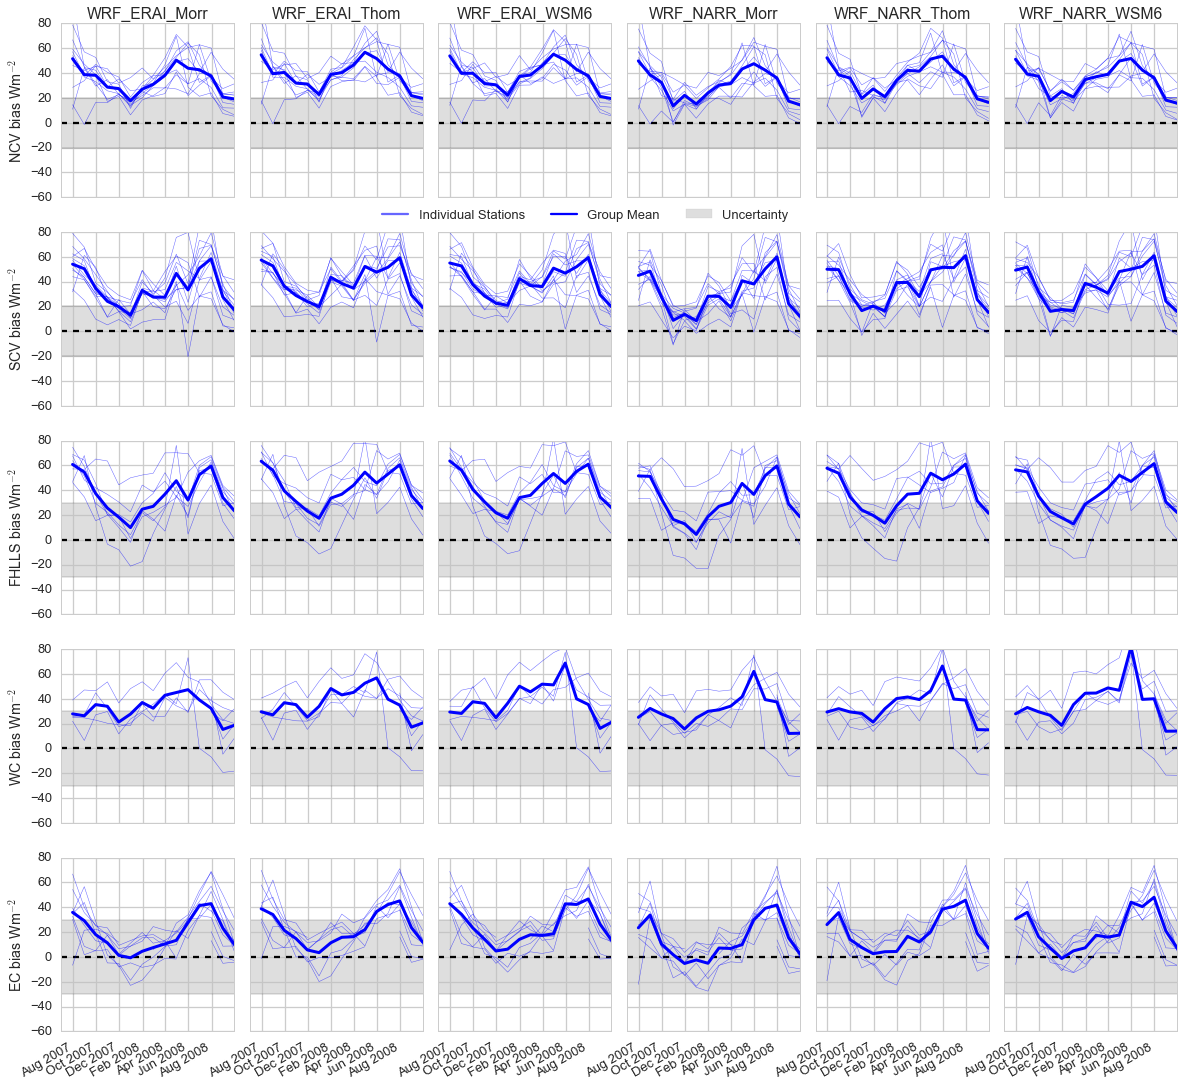

In [5]:
########################################################################
##      Time series of bias by Grouping - Panel w/ Uncertainty        ##
########################################################################
# formating preface
grouping = ['north cv','south cv','foothills','west of crest','east of crest']
grouping_shortlabel = {'north cv':'NCV','south cv':'SCV',\
                       'foothills':'FHLLS','west of crest':'WC','east of crest':'EC'}
grouping_uncertainty = {'north cv':20,'south cv':20,'foothills':30,'west of crest':30,'east of crest':30}
colsche = kgraph.SRON(5)

# Figure
fig = plt.figure(figsize=(20,20))
gs = matplotlib.gridspec.GridSpec(5,6)
gs.update(wspace=0.09)

# Date limits (WRF ensemble)
d1 = wrfSWdwn.time.values[0]
d2 = wrfSWdwn.time.values[-1]

for n,gr in enumerate(grouping):
    for m,en in enumerate(ensNames):
        ax = plt.subplot(gs[n,m])
        
        ###################
        # Shortwave Bias ##
        ###################
        ## Format Qsi bias
        ds_plot = (grobs[en]-grobs.grobs)
        ds_plot = ds_plot.swap_dims({'station':'Grouping'}).resample(freq='M', dim='time', how='mean')
 
        # Uncertainty estimate
        ax.fill_between(ds_plot.time.values,-grouping_uncertainty[gr],grouping_uncertainty[gr],\
                        facecolor='.75',alpha=.5)
        # Zero line
        ax.plot(np.array([d1,d2]),np.array([0,0]),'k--')
        # Each station
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}],\
                color='b',alpha=.6,lw=.5)
        # Group mean
        ax.plot(ds_plot.time,ds_plot.loc[{'Grouping':gr}].mean(dim='Grouping'),\
                color='b',lw=3)
  
        # Labels - products
        if n == 0:
            ax.set_title(en)
        # Labels - groups
        if m == 0:
            ax.set_ylabel(grouping_shortlabel[gr]+' bias Wm$^{-2}$')
        else:
            ax.yaxis.set_ticklabels([])
        # Legend
        if n == 0 and m == 0:
            ax.legend(ncol=1)
        # Axes limits
        ax.set_xlim(d1,d2)
        ax.set_ylim(-60,80)
    
## Legend
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
label = ['Individual Stations','Group Mean']
alpha = np.array([.6,1])
h = [mlines.Line2D([],[],color='b',label=lab, alpha=a) \
            for a,lab in zip(alpha,label)]
h.append(mpatches.Patch(color='.75',alpha=.5, label='Uncertainty'))
ax = plt.subplot(gs[0,3])
leg = ax.legend(handles=h,bbox_to_anchor=(.5, -.5, .5, .5),ncol=3)
fig.autofmt_xdate()
   
os.chdir(dir_print)
fname = 'WRFEns.SWdwn_bias_monthly.AllGroups.Uncertainty.pdf'
fig.savefig(fname)

In [6]:
def colorMapRange(data,itField,dmin=500,dmax=0):
    # Defines a colormap range for input xray.Dataset based on data minimum and maximum.
    # Minimum and maximum assume shortwave irradiance 
    
    
    for f in itField:
        # Maximum value in Dataset
        if data[f].any() \
            and not np.isnan(np.nanmax(np.squeeze(data[f].values))).any():
            dmax = max(np.nanmax(np.squeeze(data[f].values)),dmax)
            dmax = np.round(dmax/10)*10

        # Minimum value in Dataset
        if data[f].any() \
            and np.nanmin(np.squeeze(data[f].values)) > 0 \
            and not np.isnan(np.nanmin(np.squeeze(data[f].values))).any():
            dmin = min(np.nanmin(np.squeeze(data[f].values)),dmin)
            dmin = np.round(dmin/10)*10
    
    # Colormap step size
    dstep = np.round( (dmax-dmin)/10) - np.mod(np.round( (dmax-dmin)/10), 10)
    return (dmax, dmin, dstep)
    

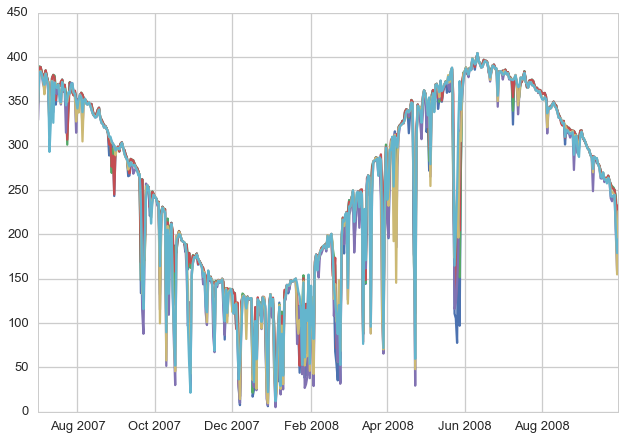

In [7]:
## Compare time series between ensemble members at the same point
for en in ensNames:
    plt.plot(wrfSWdwn.time,wrfSWdwn[en][:,50,50])


What is happening here? WRF is simulating insanely low irradiance values. It may be worth checking what the hourly time series looks like.

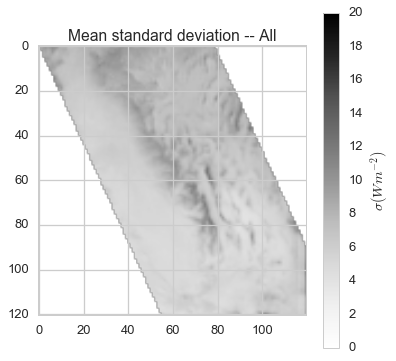

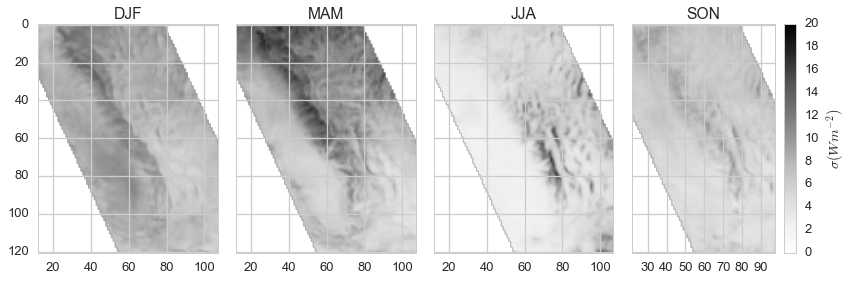

In [9]:
########################################################################
## Maps of mean standard deviation of the ensemble
########################################################################
# Combine ensemble members into a single DataArray
ds_comb = kray.combinevars(wrfSWdwn,ensNames,'ensMember','SWdwn')

### Mean - all periods
fig,ax = plt.subplots(1,1,figsize=(6,6))
imcol = ax.imshow(ds_comb.std(dim='ensMember').mean(dim='time'),vmin=0,vmax=20)
colax = plt.colorbar(imcol)
colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
ax.set_title('Mean standard deviation -- All')

# Print
os.chdir(dir_print)
fig.savefig('EnsembleDisagreement.png')
fig.savefig('EnsembleDisagreement.pdf')

### Seasonal
fig,axes = plt.subplots(1,4,sharey='row',figsize=(12,4))
seasons = ['DJF','MAM','JJA','SON']

for ax,s in zip(axes,seasons):
    # Mean - all periods
    imcol = ax.imshow(ds_comb.sel(time=(ds_comb['time.season'] == s)).std(dim='ensMember').\
                      mean(dim='time'),vmin=0,vmax=20)
    ax.set_title(s)
    if ax == axes[-1]:
        colax = plt.colorbar(imcol)
        colax.ax.set_ylabel('$\sigma (Wm^{-2})$')
fig.tight_layout()

# Print
os.chdir(dir_print)
fig.savefig('EnsembleDisagreementSeasonal.png')
fig.savefig('EnsembleDisagreementSeasonal.pdf')